In [17]:
import numpy as np
from skimage.color import rgb2gray
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras import backend as K
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_sample_weight


FASHION_5_TRANSITION_MATRIX=[[0.5, 0.2, 0.3], [0.3, 0.5, 0.2], [0.2, 0.3, 0.5]]
FASHION_6_TRANSITION_MATRIX=[[0.4, 0.3, 0.3], [0.3, 0.4, 0.3], [0.3, 0.3, 0.4]]
CIFAR_TRANSITION_MATRIX=[[0.4, 0.3, 0.3], [0.3, 0.4, 0.3], [0.3, 0.3, 0.4]] #dummy matrix

fashion5 = './data/FashionMNIST0.5.npz'
fashion6 = './data/FashionMNIST0.6.npz'
cifar = './data/CIFAR.npz'


Run RF on each model

In [26]:
classifyRf(fashion5, FASHION_5_TRANSITION_MATRIX)

Running RF on ./data/FashionMNIST0.5.npz
RF Best Validation Accuracy:  0.47711111111111115
Best Parameters:  {'max_depth': 10, 'n_estimators': 200}
RF Test Accuracy:  0.925
Estimated Transition Matrix: 
 [[0.605      0.16883333 0.22616667]
 [0.2215     0.59233333 0.18616667]
 [0.16433333 0.23083333 0.60483333]]
Actual Transition Matrix: 
 [[0.5 0.2 0.3]
 [0.3 0.5 0.2]
 [0.2 0.3 0.5]]


In [8]:
classifyRf(fashion6, FASHION_6_TRANSITION_MATRIX)

Running RF on ./data/FashionMNIST0.6.npz
RF Best Validation Accuracy:  0.3868888888888889
Best Parameters:  {'max_depth': 10, 'n_estimators': 200}
RF Test Accuracy:  0.862
Estimated Transition Matrix: 
 [[0.60816667 0.19966667 0.19216667]
 [0.1485     0.63366667 0.21783333]
 [0.1245     0.18566667 0.68983333]]
Actual Transition Matrix: 
 [[0.4, 0.3, 0.3], [0.3, 0.4, 0.3], [0.3, 0.3, 0.4]]


In [7]:
classifyRf(cifar, CIFAR_TRANSITION_MATRIX)

Running RF on ./data/CIFAR.npz
RF Best Validation Accuracy:  0.3648666666666667
Best Parameters:  {'max_depth': 10, 'n_estimators': 200}
RF Test Accuracy:  0.5046666666666667
Estimated Transition Matrix: 
 [[0.9684 0.011  0.0206]
 [0.1406 0.829  0.0304]
 [0.137  0.03   0.833 ]]
Actual Transition Matrix: 
 [[0.4, 0.3, 0.3], [0.3, 0.4, 0.3], [0.3, 0.3, 0.4]]


In [3]:
def getData(file_path):
  dataset = np.load(file_path)
  xtr_val = dataset['Xtr']
  str_val = dataset['Str']
  xts = dataset['Xts']
  yts = dataset['Yts']

  #convert to greyscale
  if xtr_val.shape[-1] == 3:
        xtr_val = rgb2gray(xtr_val)
        xts = rgb2gray(xts)

  #flatten the image into 1D array
  xtr_val = xtr_val.reshape(xtr_val.shape[0], -1)
  xts = xts.reshape(xts.shape[0], -1)

  #normalize the data
  xtr_val = xtr_val.astype('float32') / 255.
  xts = xts.astype('float32') / 255.

  return xtr_val, str_val, xts, yts

Random Forest

In [25]:
def classifyRf(filename, transition_matrix, count=2): #count should be 10 according to 2.1.1

    print("Running RF on", filename)

    xtr_val, str_val, xts, yts = getData(filename)

    # Preprocessing
    num_classes = len(np.unique(str_val))
    str_val_categorical = to_categorical(str_val, num_classes)

    # Compute sample weights based on the inverse of the transition matrix
    # Assuming the transition_matrix is of the shape (num_classes, num_classes)
    # and the element T[i, j] is the probability of class i being mislabeled as class j.
    # Ensure transition_matrix is a numpy array
    transition_matrix = np.array(transition_matrix)

    # Calculate sample weights using the diagonal of the transition matrix
    sample_weights = np.array([1 / transition_matrix[j][j] for j in str_val])

    
    # Define the parameter grid for hyperparameter tuning
    param_grid = {
        'n_estimators': [200],
        'max_depth': [10]
        #'n_estimators': [50, 100, 200],
        #'max_depth': [10, 20, None]
    }

    rf = RandomForestClassifier()

    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=count, scoring='accuracy')

    grid_search.fit(xtr_val, np.argmax(str_val_categorical, axis=1), sample_weight=sample_weights)

    best_rf = grid_search.best_estimator_
    best_score = grid_search.best_score_
    
    print("RF Best Validation Accuracy: ", best_score)
    print("Best Parameters: ", grid_search.best_params_)

    best_rf.fit(xtr_val, np.argmax(str_val_categorical, axis=1), sample_weight=sample_weights)
    
    yts_pred = best_rf.predict(xts)
    test_accuracy = accuracy_score(yts, yts_pred)
    print("RF Test Accuracy: ", test_accuracy)

    str_val_pred = best_rf.predict(xtr_val)
    
    # Construct confusion matrix using predicted and noisy labels
    conf_matrix = confusion_matrix(np.argmax(str_val_categorical, axis=1), str_val_pred)

    # Normalize the confusion matrix to estimate the transition matrix
    estimated_transition_matrix = normalize(conf_matrix, axis=1, norm='l1')
    print("Estimated Transition Matrix: \n", estimated_transition_matrix)
    print("Actual Transition Matrix: \n", transition_matrix)

CNN

In [5]:
def custom_loss(transition_matrix):
    def loss(y_true, y_pred):
        y_pred_adjusted = K.dot(y_pred, K.constant(transition_matrix, dtype='float32'))
        return K.categorical_crossentropy(y_true, y_pred_adjusted)
    return loss

def build_cnn(input_shape, num_classes, transition_matrix):
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(loss=custom_loss(transition_matrix), optimizer='adam', metrics=['accuracy'])
    return model

def preprocess_data(x, y, num_classes):
    x = x.reshape(x.shape[0], x.shape[1], x.shape[2], 1).astype('float32') / 255
    y = to_categorical(y, num_classes)
    return x, y

def evaluate_model(cnn, x_test, y_test):
    predictions = cnn.predict(x_test)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y_test, axis=1)
    return accuracy_score(true_classes, predicted_classes)

def classifyCnn(filename, transition_matrix, count=1):
    xtr_val, ytr_val, xts, yts = getData(filename)
    num_classes = len(np.unique(ytr_val))

    xtr_val, ytr_val = preprocess_data(xtr_val, ytr_val, num_classes)
    xts, yts = preprocess_data(xts, yts, num_classes)

    accuracies = []
    for _ in range(count):
        cnn = build_cnn(xtr_val.shape[1:], num_classes, transition_matrix)
        cnn.fit(xtr_val, ytr_val, epochs=10, batch_size=64, verbose=0)
        acc = evaluate_model(cnn, xts, yts)
        accuracies.append(acc)

    print("CNN Average Validation Accuracy: ", np.mean(accuracies))


Visuals

TypeError: Invalid shape (1024,) for image data

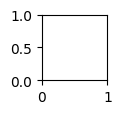

In [6]:
EXAMPLES=10
# An ordered list of the CIFAR class names
CIFAR_CLASS_NAMES = ["0. Plane", "1. Car", "2. Cat"]
CIFAR_CATEGORY_LABELS = dict(zip(map(str, list(range(3))), CIFAR_CLASS_NAMES))

FASHION_CLASS_NAMES = ["0. T-shirt", "1. Pants", "2. Dress"]
FASHION_CATEGORY_LABELS = dict(zip(map(str, list(range(3))), FASHION_CLASS_NAMES))

cifar_xtr, cifar_str, cifar_xts, cifar_yts = getData('./data/CIFAR.npz')
# print('CIFAR\n---------------')
# print('Training samples:\n', pd.DataFrame(cifar_str).value_counts())
# print('Test samples:\n', pd.DataFrame(cifar_yts).value_counts())

fashion5_xtr, fashion5_str, fashion5_xts, fashion5_yts = getData('./data/FashionMNIST0.5.npz')
# print('Fashion 0.5\n---------------')
# print('Training samples:\n', pd.DataFrame(fashion5_str).value_counts())
# print('Test samples:\n', pd.DataFrame(fashion5_yts).value_counts())

fashion6_xtr, fashion6_str, fashion6_xts, fashion6_yts = getData('./data/FashionMNIST0.6.npz')
# print('Fashion 0.6\n---------------')
# print('Training samples:\n', pd.DataFrame(fashion6_str).value_counts())
# print('Test samples:\n', pd.DataFrame(fashion6_yts).value_counts())

def plot_examples(title, data_set, data_noisy_labels, categories, examples, category_labels):
  fig = plt.figure(figsize=(examples, categories))  # Added a figure instance with a specified size
  count = 1
  for i in range(categories):
    categoryIndeces = np.where(data_noisy_labels == i)
    for j in range(examples):
      plt.subplot(categories, examples, count),
      plt.imshow(data_set[categoryIndeces[0][j]], cmap = 'binary')
      plt.title(category_labels[str(data_noisy_labels[categoryIndeces[0][j]])]), plt.xticks([]), plt.yticks([])
      count += 1
  
  fig.suptitle(title, fontsize=16)
  plt.tight_layout()
  plt.show()
  plt.close()

plot_examples('CIFAR Training Data', cifar_xtr, cifar_str, len(CIFAR_CLASS_NAMES), EXAMPLES, CIFAR_CATEGORY_LABELS)
plot_examples('CIFAR Test Data', cifar_xts, cifar_yts, len(CIFAR_CLASS_NAMES), EXAMPLES, CIFAR_CATEGORY_LABELS)

plot_examples('Fashion 0.5 Training Data', fashion5_xtr, fashion5_str, len(FASHION_CLASS_NAMES), EXAMPLES, FASHION_CATEGORY_LABELS)
plot_examples('Fashion 0.5 Test Data', fashion5_xts, fashion5_yts, len(FASHION_CLASS_NAMES), EXAMPLES, FASHION_CATEGORY_LABELS)

plot_examples('Fashion 0.6 Training Data', fashion6_xtr, fashion6_str, len(FASHION_CLASS_NAMES), EXAMPLES, FASHION_CATEGORY_LABELS)
plot_examples('Fashion 0.6 Test Data', fashion6_xts, fashion6_yts, len(FASHION_CLASS_NAMES), EXAMPLES, FASHION_CATEGORY_LABELS)